# NLP: Disaster Tweets

This Kaggle challenge is to classify a given Tweet as referencing a disaster
or not referencing a disaster. That is to say, we solve a binary
classification problem on a natural language dataset.

One pecularity we see is that the language is very natural, so to say.
Nonstandard written English is expected and syntax will be bent by the inclusion of
hashtags and ats. Our goal is to classify the data entirely on the text.
While some conclusion can be drawn from the keyword label, I feel this problem is
best approached for educational purposes as a general binary classification on text.
Here we attempt to solve this problem by a few different neural network
architectures on text.

We try a bidirection RNN architecture, a convolutional neural network,
and lastly we use a massive pretrained model BERT.

We begin with importing modules and peaking at the dataset.

## Import statements

In [ ]:
import os
import sys
import logging
import itertools

import pandas as pd
import numpy as np
import re
import sklearn.metrics
import sklearn.preprocessing

import tensorflow as tf
import tensorflow_hub as hub
import bert
import bert.tokenization

import nltk
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import wordcloud

## Logging and formatting

While the Pandas warning for chained assignments is important to remind
a coder that DataFrames pass references with assignment unless *copy* is called,
at one point I do want to simply work on the slices and mutate them without
unnecessarily duplicated the data. Thus it is turned off, and it probably be off 
by default.

Here I make a logging object for no better reason than its probably good
practice and should be templated code that appears at the top of any module.

In [ ]:
init_notebook_mode(connected=True)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 160

log = logging.getLogger(name=__name__)
log.setLevel(logging.INFO)
logging.captureWarnings(True)
formatter = logging.Formatter(
    '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.INFO)

stream_handler.setFormatter(formatter)
log.addHandler(stream_handler)

The TensorFlow random seed is set for replicability.

In [ ]:
SEED = 1
tf.random.set_seed(SEED)

Here is another bit of template code where we log
the package versions to console.

In [ ]:
log.info(f"Python version: {sys.version}")
log.info(f"Numpy version: {np.__version__}")
log.info(f"Pandas version: {pd.__version__}")
log.info(f"Scikit-learn version: {sklearn.__version__}")
log.info(f"TensorFlow version: {tf.__version__}")
log.info(f"Plotly version: {plotly.__version__}")
log.info(f"WordCloud version: {wordcloud.__version__}")
log.info(f"tensorflow.random seed: {SEED}")

After peaking ahead and looking into the column names of the tabulated data,
it is good to define constants with these column names if each one is to have
its own special preprocessing. This makes the code more easily replicable
and adaptable to changes to the input data.

In the preprocessing step, hashtags and at's need to be substituted with a 
replacement string. Because we use the BERT pretrained model with its own
preset tokenizer, we cannot use a strictly symbolic replacement as one would hope to use.
Consequentially, we replace at's with "recipient" and a given numeral with "number."

I also like to define *SUCCESS* as *0* since I have grown fond of the C like way
of handling functions and their return values. Because Pandas API is build around C++ arrays, many of the methods
alter a Series or DataFrame inplace, so it is more natural to think of void return types
or better yet int return types for preprocessing functions. 
In fact, one of my primary confusions when learn Pandas was trying to understand
when the API preferred a new object being created (see the *merge*, *drop*, *astype* methods)
and when it preferred the Series or DataFrame be altered inplace.
This is a point of confusion
to non-computer science people entering into data science. it is my objective to 
avoid methods that make new DataFrames if the transformation can be done on the fixed object,
and so I prefer returning *SUCCESS* instead of a DataFrame if I can help it.

In [1]:
SUCCESS = 0

UNK = "UNK"
NUM = "number"
AT = "recipient"
http = "http"
html = "html"

target = "target"
keyword = "keyword"
old_text = "text"
location = "location"
text = "t"
hashtag = "hashtag"
at = "at"
href = "href"

y_cols = [target+"_0", target+"_1"]

2020-11-12 00:01:00,471 - __main__ - INFO - Python version: 3.8.0 (default, Oct 28 2019, 16:14:01) 
[GCC 8.3.0]
2020-11-12 00:01:00,471 - __main__ - INFO - Numpy version: 1.18.5
2020-11-12 00:01:00,471 - __main__ - INFO - Pandas version: 1.1.4
2020-11-12 00:01:00,472 - __main__ - INFO - Scikit-learn version: 0.23.2
2020-11-12 00:01:00,472 - __main__ - INFO - TensorFlow version: 2.3.0
2020-11-12 00:01:00,474 - __main__ - INFO - Plotly version: 4.12.0
2020-11-12 00:01:00,474 - __main__ - INFO - WordCloud version: 1.8.0
2020-11-12 00:01:00,475 - __main__ - INFO - tensorflow.random seed: 1
2020-11-12 00:01:00,476 - __main__ - INFO - Data directory: /home/jimmy/github/kaggle/nlp_disaster_tweets/data
2020-11-12 00:01:00,503 - __main__ - INFO - Training data shape: (7613, 5)
2020-11-12 00:01:00,504 - __main__ - INFO - Test data shape: (3263, 4)


In [ ]:
stopwords = (nltk.corpus.stopwords.words("english") 
    + ["u", "im", "st", "nd", "rd", "th"]
)

data_bn = "data"
data_dir = os.path.abspath(
    os.path.join(__name__, os.pardir, os.pardir, data_bn)
)

log.info(f"Data directory: {data_dir}")

train_bn = "train.csv"
test_bn = "test.csv"
train_fn = os.path.join(data_dir, train_bn)
test_fn = os.path.join(data_dir, test_bn)

df_train = pd.read_csv(train_fn)
df_test = pd.read_csv(test_fn)

log.info(f"Training data shape: {df_train.shape}")
log.info(f"Test data shape: {df_test.shape}")

train_pts = df_train.shape[0]

In [2]:
def to_lower(df, col=text):
    """
    Casefolds (casts to lower case) text column of dataframe ${df} inplace.
    """
    df[col] = df[col].apply(lambda x: x.casefold())
    
    return SUCCESS


def hash_handling(df, col=text):
    """
    Removes # as well as copying strings of the form #\w+ into
        a new column called ${hastag}. This function alters ${df} inplace.
    """
    reg_hash_full = re.compile("(#)\w+")
    reg_hash = re.compile("(#)")
    
    f = lambda x: [y.group() for y in reg_hash_full.finditer(x)]
    g = lambda x: ' '.join(x)
    
    df[hashtag] = df[text].apply(f).apply(g)
    df[col] = df[col].apply(lambda x: reg_hash.sub(' ', x))
    
    return SUCCESS


def at_handling(df, col=text):
    """
    Removes words of the form @\w+ replacing those with the literal ${AT}
        as well as preserving the strings of the form @\w+ in the new
        column ${at}. This function alters ${df} inplace.
    """
    reg_at = re.compile("(@)")
    reg_at_full = re.compile("(@)\w+")
    
    f = lambda x: [y.group() for y in reg_at_full.finditer(x)]
    g = lambda x: ' '.join(x)
    
    df[at] = df[col].apply(f).apply(g)
    df[col] = df[col].apply(lambda x: reg_at_full.sub(' '+AT+' ', x))
    
    return SUCCESS


def href_handling(df, col=text):
    """
    Removes links in the text and replaces those with the string ${http}
        while counting the number of links in the text. The total count
        is saved in the column ${href}.
    """
    reg_href_full = re.compile("(htt)\S+")
    
    f = lambda x: len(list(reg_href_full.finditer(x)))
    
    df[href] = df[col].apply(f)
    df[col] = df[col].apply(lambda x: reg_href_full.sub(' '+http+' ', x))
    
    return SUCCESS


def html_special_handling(df, col=text):
    """
    Removes HTML escape characters of the form &\w+;.
    """
    reg_html = re.compile("(&)\w+(;)")
    df[col] = df[col].apply(lambda x: reg_html.sub(' '+html+' ', x))
    
    return SUCCESS
    
    
def xc2x89_byte_handling(df, col=text):
    """
    Removes continuation byte sequence b'\xc2\x89'.
    """
    reg_x89 = re.compile(b"\xc2\x89".decode('utf-8')+"\S+")
    df[col] = df[col].apply(lambda x: reg_x89.sub(' ', x))
    
    return SUCCESS
    
    
def special_char_handling(df, col=text):
    """
    Removes special characters.
    """
    reg_special = re.compile("[^\w\s]")
    df[col] = df[col].apply(lambda x: reg_special.sub(' ', x))
    df[col] = df[col].apply(lambda x: re.sub('_', ' ', x)) 
    
    return SUCCESS


def contraction_handling(df, col=text):
    """
    """
    reg_contract = re.compile("\s(s|m|t|(nt)|(ve)|w)\s")
    df[col] = df[col].apply(lambda x: reg_contract.sub(' ', x))
    
    return SUCCESS


def encode_numerals(df, col=text):
    """
    """
    reg_numerals = re.compile("\d+[\s\d]*")
    df[col] = df[col].apply(lambda x: reg_numerals.sub(' '+NUM+' ', x))
    
    return SUCCESS
    
    
def remove_stopwords(df, col=text):
    """
    """
    f = (lambda x: 
        ' '.join([y for y in x.strip().split() if y not in stopwords])
    )
    df[col] = df[col].apply(f)
    
    return SUCCESS   


def has_location(df):
    """
    """
    df[location] = df[location].apply(lambda x: 1 if pd.isnull(x) else 0)
    
    return SUCCESS


def preprocess(df):
    """
    """
    df[text] = df[old_text]
    to_lower(df)
    hash_handling(df)
    at_handling(df)
    href_handling(df)
    html_special_handling(df)
    xc2x89_byte_handling(df)
    special_char_handling(df)
    contraction_handling(df)
    remove_stopwords(df)
    encode_numerals(df)
    has_location(df)
    
    return SUCCESS

In [3]:
_ = preprocess(df_train)
_ = preprocess(df_test)

In [4]:
df_train.head(20)

,id,keyword,location,text,target,t,hashtag,at,href
0,1,NaN,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deeds reason earthquake may allah forgive us,#earthquake,,0
1,4,NaN,1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,,,0
2,5,NaN,1,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,residents asked shelter place notified officers evacuation shelter place orders expected,,,0
3,6,NaN,1,"13,000 people receive #wildfires evacuation orders in California",1,number people receive wildfires evacuation orders california,#wildfires,,0
4,7,NaN,1,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,got sent photo ruby alaska smoke wildfires pours school,#alaska #wildfires,,0
5,8,NaN,1,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1,rockyfire update california hwy number closed directions due lake county fire cafire wildfires,#rockyfire #cafire #wildfires,,0
6,10,NaN,1,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1,flood disaster heavy rain causes flash flooding streets manitou colorado springs areas,#flood #disaster,,0
7,13,NaN,1,I'm on top of the hill and I can see a fire in the woods...,1,top hill see fire woods,,,0
8,14,NaN,1,There's an emergency evacuation happening now in the building across the street,1,emergency evacuation happening building across street,,,0
9,15,NaN,1,I'm afraid that the tornado is coming to our area...,1,afraid tornado coming area,,,0


In [5]:
df_test.head(20)

,id,keyword,location,text,t,hashtag,at,href
0,0,NaN,1,Just happened a terrible car crash,happened terrible car crash,,,0
1,2,NaN,1,"Heard about #earthquake is different cities, stay safe everyone.",heard earthquake different cities stay safe everyone,#earthquake,,0
2,3,NaN,1,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",forest fire spot pond geese fleeing across street cannot save,,,0
3,9,NaN,1,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,#spokane #wildfires,,0
4,11,NaN,1,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills number china taiwan,,,0
5,12,NaN,1,We're shaking...It's an earthquake,shaking earthquake,,,0
6,21,NaN,1,"They'd probably still show more life than Arsenal did yesterday, eh? EH?",probably still show life arsenal yesterday eh eh,,,0
7,22,NaN,1,Hey! How are you?,hey,,,0
8,27,NaN,1,What a nice hat?,nice hat,,,0
9,29,NaN,1,Fuck off!,fuck,,,0


2020-11-12 00:01:01,036 - __main__ - ERROR - ...


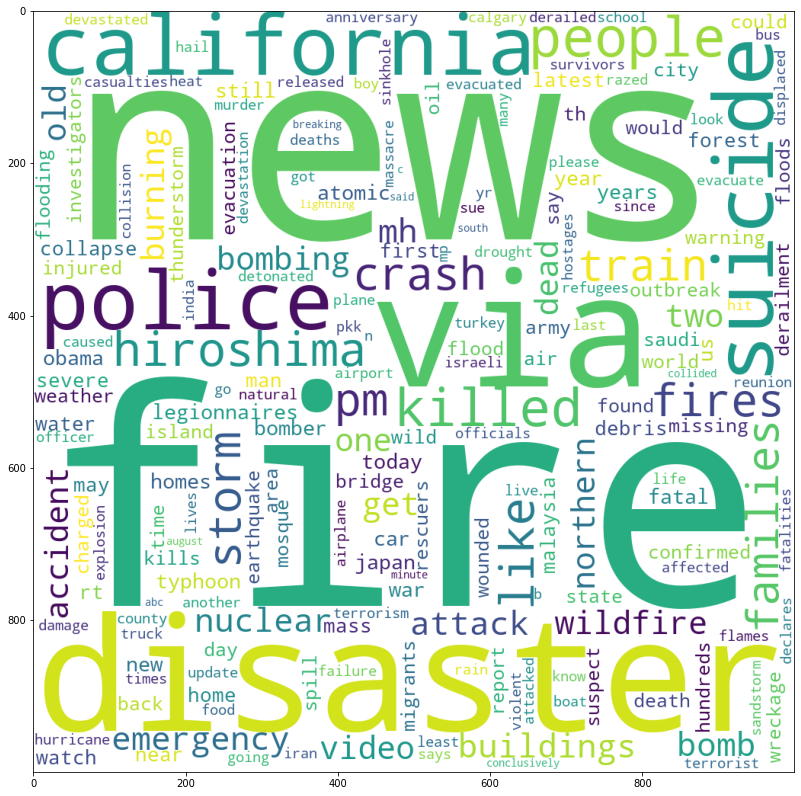

In [6]:
tokenize_flatten = lambda series: (
    list(itertools.chain(*[x.split() for x in series]))
)

wc_size = (14, 14)

tdf = df_train[df_train[target]==1]

unique_words, word_counts = (
    np.unique(tokenize_flatten(tdf[text]), return_counts=True)
)
sm = np.sum(word_counts)
frequency_dict = {
    x: word_counts[i]/sm 
        for i, x in np.ndenumerate(unique_words)
}
try:
    frequency_dict.pop(NUM)
    frequency_dict.pop(AT)
    frequency_dict.pop(http)
    frequency_dict.pop(html)
except:
    log.error("...")
try:
    frequency_dict.pop(UNK)
except:
    log.error("...")

wc = wordcloud.WordCloud(
    width=1000, height=1000, 
    background_color='white',
    min_font_size=10
).generate_from_frequencies(frequency_dict)
fig = plt.figure(figsize=wc_size, facecolor=None)
ax = fig.add_subplot()
a = ax.imshow(wc) 

2020-11-12 00:01:03,008 - __main__ - ERROR - ...


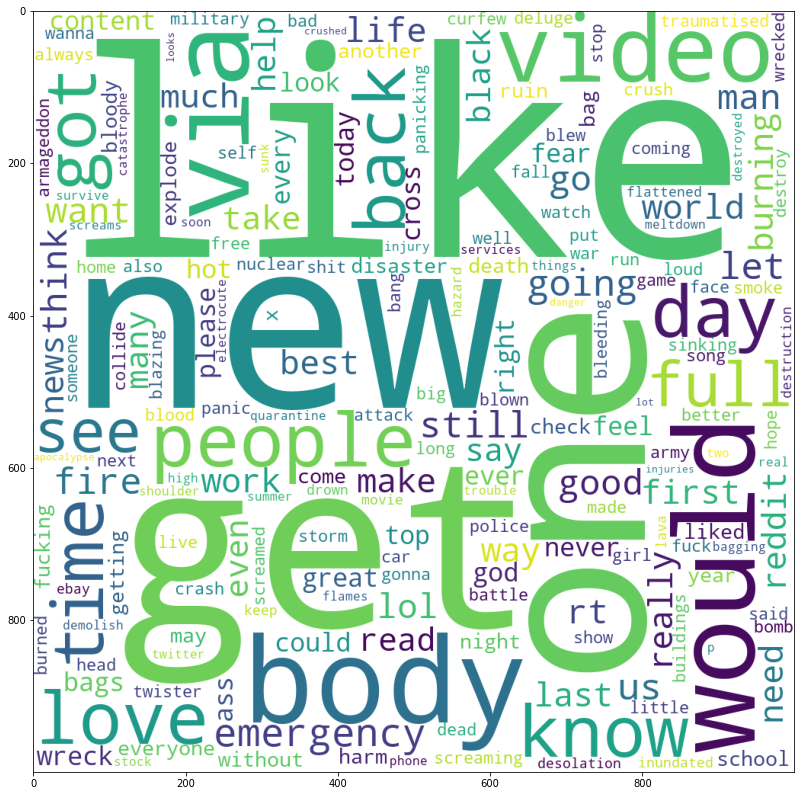

In [7]:
tdf = df_train[df_train[target]==0]
unique_words, word_counts = (
    np.unique(tokenize_flatten(tdf[text]), return_counts=True)
)
sm = np.sum(word_counts)
frequency_dict = {
    x: word_counts[i]/sm
    for i, x in np.ndenumerate(unique_words)
}
try:
    frequency_dict.pop(NUM)
    frequency_dict.pop(AT)
    frequency_dict.pop(http)
    frequency_dict.pop(html)
except:
    log.error("Key not found.")
try:
    frequency_dict.pop(UNK)
except:
    log.error("...")

wc = wordcloud.WordCloud(
    width=1000, height=1000, 
    background_color='white',
    min_font_size=10
).generate_from_frequencies(frequency_dict)
fig = plt.figure(figsize=wc_size, facecolor=None) 
ax = fig.add_subplot()
ret = ax.imshow(wc) 

In [8]:
def bigrams_count(df, col, top_n=10):
    """
    Count top ${top_n} bigrams in ${df} under column ${col}.
    
    Args:
        df (pandas.DataFrame): Dataframe with text data.
        col (str): Column of ${df}'s text data.
        top_n (int): How many of the most frequent bigrams to return.
        
    Returns:
        (numpy.ndarray): Array of shape (2, N) where first row
            is the unique bigrams and second row is the number of counts
            for each bigram.
    """
    words = [x.split() for x in df[col]]
    bigrams = [x[i]+"_"+x[i+1] for x in words for i in range(len(x)-1)]
    
    uniq_pairs, counts = np.unique(np.array(bigrams), return_counts=True)
        
    return np.array([uniq_pairs, counts])

In [9]:
df_bi_0 = pd.DataFrame(
    bigrams_count(df_train[df_train[target]==0], text).T, 
    columns=["bigram", "count"]
)
df_bi_1 = pd.DataFrame(
    bigrams_count(df_test[df_train[target]==0], text).T, 
    columns=["bigram", "count"]
)

df_bi = df_bi_0.merge(df_bi_1, how="outer", left_on="bigram", 
                      suffixes=("_0", "_1"), right_on="bigram")
df_bi.fillna(0, inplace=True)
df_bi = df_bi.astype({"count_0": int, "count_1": int})
df_bi["total"] = df_bi["count_0"] + df_bi["count_1"]

In [10]:
top_n = 100
top_bigrams = df_bi.nlargest(top_n, "total")

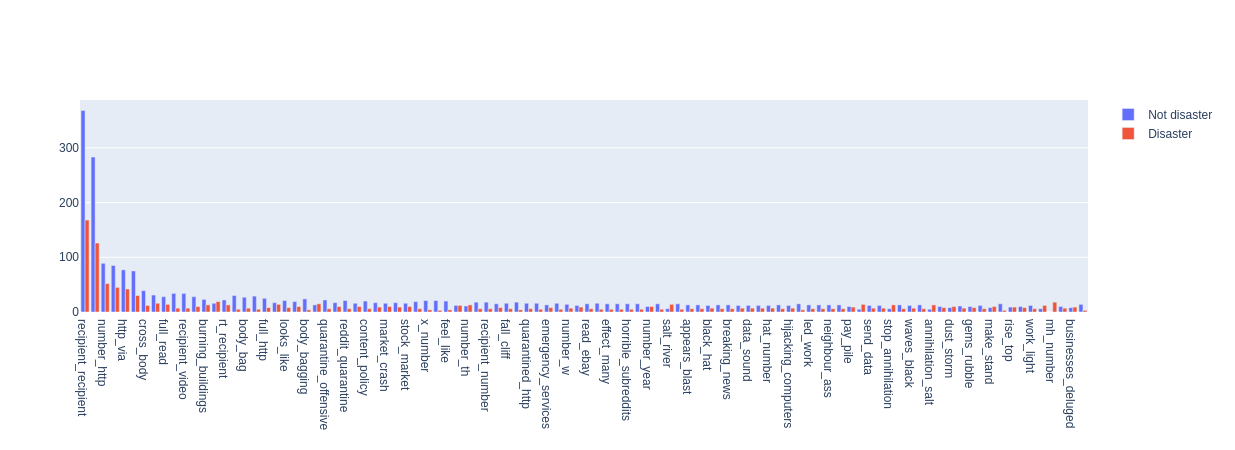

In [11]:
fig = go.Figure()
bar0 = go.Bar(name="Not disaster", 
              x=top_bigrams["bigram"], 
              y=top_bigrams["count_0"]
)
bar1 = go.Bar(name="Disaster",
              x=top_bigrams["bigram"],
              y=top_bigrams["count_1"]
)

fig.add_trace(bar0)
fig.add_trace(bar1)

fig.update_layout(barmode='group')

iplot(fig)

In [12]:
def tokenize_dataframe(df, col, max_len=20):
    """
    """
    df_tmp = pd.DataFrame(
        df[col].apply(lambda x: reversed(x.split())).tolist()
    )
    orig_len = len(df_tmp.columns)
    df_tmp = df_tmp.rename(
        lambda x: col+"_{:02d}".format(max_len-1-x), 
        axis=1
    )
    
    enum_cols = [col+"_{:02d}".format(i) for i in range(max_len)]
    if orig_len < max_len:
        compl_cols = [x for x in enum_cols if x not in df_tmp.columns]
        df_tmp[compl_cols] = np.nan
    
    df[enum_cols] = df_tmp[enum_cols]
    
    return enum_cols


def filter_infrequent(df, cols, cutoff=5):
    """
    """
    unique_words, word_counts = (
        np.unique(df[cols].values.flatten(), return_counts=True)
    )
    infreq_dict = {
        x: (x if word_counts[i] >= cutoff else UNK)
            for i, x in np.ndenumerate(unique_words)
    }

    f = lambda x: infreq_dict[x]
    df[cols] = df[cols].applymap(f)
    
    return SUCCESS


def transform_data(df):
    """
    """
    word_cols = tokenize_dataframe(df, text, max_len=25)
    
    df[word_cols] = df[word_cols].fillna('')
    
    lemmatizer = nltk.stem.WordNetLemmatizer() 
    ps = nltk.stem.PorterStemmer()

    df[word_cols] = df[word_cols].applymap(lambda x: ps.stem(x))
    df[word_cols] = df[word_cols].applymap(lambda x: lemmatizer.lemmatize(x))

    _ = filter_infrequent(df, word_cols, cutoff=10)
        
    word_enc = sklearn.preprocessing.LabelEncoder()#LabelEncoderExt()
    df[word_cols] = (word_enc
        .fit_transform(df[word_cols].values.flatten())
        .reshape(df[word_cols].shape)
    )

    num_unique_words = word_enc.classes_.shape[0]
    
    return word_enc, num_unique_words, word_cols

In [13]:
def bert_tokenize(df, col):
    """
    """
    gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"

    tf.io.gfile.listdir(gs_folder_bert)

    tokenizer = bert.tokenization.FullTokenizer(
        vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
        do_lower_case=True
    )

    bert_token = (lambda x: tokenizer
        .convert_tokens_to_ids(['[CLS]'] + tokenizer.tokenize(x) + ['[SEP]'])
    )
    
    num_unique_words = len(tokenizer.vocab)

    pre_words_ids = df[col].apply(bert_token)
    pre_masks = df[col].apply(lambda x: [1]*(len(tokenizer.tokenize(x))+2))

    words_ids = tf.keras.preprocessing.sequence.pad_sequences(pre_words_ids)
    masks = tf.keras.preprocessing.sequence.pad_sequences(pre_masks)
    type_ids = np.zeros(words_ids.shape, dtype=np.int)

    word_cols = [text+"_{:02d}".format(i) for i in range(words_ids.shape[1])]
    mask_cols = ["mask"+"_{:02d}".format(i) for i in range(words_ids.shape[1])]
    type_cols = ["type"+"_{:02d}".format(i) for i in range(words_ids.shape[1])]

    df[word_cols] = words_ids
    df[mask_cols] = masks
    df[type_cols] = type_ids
    
    return tokenizer, num_unique_words, word_cols, mask_cols, type_cols

In [14]:
def tf_tokenizer(df, col, num_words):
    """
    """
    tokenizer = (
        tensorflow.keras.preprocessing.text.Tokenizer(num_words=num_words)
    )
    tokenizer.fit_on_texts(df[col].values)
    word_ar = tf.keras.preprocessing.sequence.pad_sequences(
        tokenizer.texts_to_sequences(df[col].values)
    )
    word_cols = ["text_{:02d}".format(i) for i in range(word_ar.shape[1])]
    df[word_cols] = word_ar
    
    return tokenizer, num_words, word_cols

In [15]:
df_full = pd.concat([df_train, df_test], ignore_index=True)

#word_enc, num_unique_words, word_cols = transform_data(df_full)
#tokenizer, num_unique_words, word_cols = tf_tokenizer(df_full, text, 1000)
tokenizer, num_unique_words, word_cols, mask_cols, type_cols = bert_tokenize(df_full, text)

log.info(f"Vocab size: {num_unique_words}")

2020-11-12 00:01:09,077 - __main__ - INFO - Vocab size: 30522


In [16]:
df_full.head(10)

,id,keyword,location,text,target,t,hashtag,at,href,t_00,t_01,t_02,t_03,t_04,t_05,t_06,t_07,t_08,t_09,t_10,t_11,t_12,t_13,t_14,t_15,t_16,t_17,t_18,t_19,t_20,t_21,t_22,t_23,t_24,t_25,t_26,t_27,t_28,t_29,t_30,t_31,t_32,t_33,t_34,t_35,t_36,t_37,t_38,t_39,t_40,t_41,t_42,t_43,t_44,t_45,t_46,mask_00,mask_01,mask_02,mask_03,mask_04,mask_05,mask_06,mask_07,mask_08,mask_09,mask_10,mask_11,mask_12,mask_13,mask_14,mask_15,mask_16,mask_17,mask_18,mask_19,mask_20,mask_21,mask_22,mask_23,mask_24,mask_25,mask_26,mask_27,mask_28,mask_29,mask_30,mask_31,mask_32,mask_33,mask_34,mask_35,mask_36,mask_37,mask_38,mask_39,mask_40,mask_41,mask_42,mask_43,mask_44,mask_45,mask_46,type_00,type_01,type_02,type_03,type_04,type_05,type_06,type_07,type_08,type_09,type_10,type_11,type_12,type_13,type_14,type_15,type_16,type_17,type_18,type_19,type_20,type_21,type_22,type_23,type_24,type_25,type_26,type_27,type_28,type_29,type_30,type_31,type_32,type_33,type_34,type_35,type_36,type_37,type_38,type_39,type_40,type_41,type_42,type_43,type_44,type_45,type_46
0,1,NaN,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,deeds reason earthquake may allah forgive us,#earthquake,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,101,15616,3114,8372,2089,16455,9641,2149,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4,NaN,1,Forest fire near La Ronge Sask. Canada,1.0,forest fire near la ronge sask canada,,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,101,3224,2543,2379,2474,6902,3351,21871,2243,2710,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5,NaN,1,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0,residents asked shelter place notified officers evacuation shelter place orders expected,,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,101,3901,2356,7713,2173,19488,3738,13982,7713,2173,4449,3517,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,NaN,1,"13,000 people receive #wildfires evacuation orders in California",1.0,number people receive wildfires evacuation orders california,#wildfires,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,101,2193,2111,4374,3748,26332,13982,4449,2662,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,7,NaN,1,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0,got sent photo ruby alaska smoke wildfires pours school,#alaska #wildfires,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,101,2288,2741,6302,10090,7397,5610,3748,26332,10364,2015,2082,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,8,NaN,1,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1.0,rockyfire update california hwy number closed directions due lake county fire cafire wildfires,#rockyfire #cafire #wildfires,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,101,6857,10273,10651,2662,1044,18418,2193,2701,7826,2349,2697,2221,2543,24689,7442,3748,26332,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [17]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"
bert_layer = hub.KerasLayer(hub_url_bert, trainable=True)

In [18]:
class TwolayerModel(tf.keras.Model):
    """
    """
    def __init__(self,
        batch_size=32,
        units=40,
        embed_dim=100,
        sequence_length=len(word_cols),
    ):
        """
        """
        super(TwolayerModel, self).__init__()

        self.inps = (None, sequence_length)
        self.bs = batch_size
        out_dim = 2        
        
        self._embed1 = tf.keras.layers.Embedding(
            num_unique_words,
            embed_dim,
            input_length=self.inps[1],
            name="word_embedding",
        )
        self._lstm1 = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                units,
                name="lstm1",
                return_sequences=True,
            )
        )
        
        self._lstm2 = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                units,
                name="lstm2",
            )
        )

        self._dense2 = tf.keras.layers.Dense(
            out_dim,
            activation=tf.nn.softmax,
            name="final",
        )
        
        self._optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        self._metrics = [tf.keras.metrics.BinaryAccuracy()]
        self._loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        #self._loss = tf.keras.losses.KLDivergence()
        
        self.compile(
            optimizer=self._optimizer,
            loss=self._loss,
            metrics=self._metrics,
        )

        self.build(self.inps)
        

    def call(self, inputs):        
        x1 = self._embed1(inputs)
        y1 = self._lstm1(x1)
        y1 = self._lstm2(y1)
        out = self._dense2(y1)
        
        return out

In [19]:
class OnelayerModel(tf.keras.Model):
    """
    """
    def __init__(self,
            batch_size=32,
            units=40,
            embed_dim=100,
            sequence_length=len(word_cols),
    ):
        """
        """
        super(OnelayerModel, self).__init__()

        self.inps = [
            (None, sequence_length),
            (None, sequence_length),
            (None, sequence_length),
        ]
        self.bs = batch_size
        out_dim = 2
              
        self._embed1 = tf.keras.layers.Embedding(
            num_unique_words,
            embed_dim,
            input_length=self.inps[0][1],
            name="word_embedding",
        )
        self._lstm1 = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                units,
                name="lstm1",
            )
        )
        
        self._dense2 = tf.keras.layers.Dense(
            out_dim,
            activation=tf.nn.softmax,
            name="final",
        )
        
        self._optimizer = tf.keras.optimizers.Adam(
                            learning_rate=0.0001
        )
        self._metrics = [tf.keras.metrics.BinaryAccuracy()]
        self._loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        #self._loss = tf.keras.losses.KLDivergence()
        
        self.compile(
            optimizer=self._optimizer,
            loss=self._loss,
            metrics=self._metrics,
        )

        self.build(self.inps[0])
        

    def call(self, inputs):        
        x1 = self._embed1(inputs)
        y1 = self._lstm1(x1)
        out = self._dense2(y1)
        
        return out

In [20]:
class ConvModel(tf.keras.Model):
    """
    """
    def __init__(self,
            batch_size=32,
            units=40,
            embed_dim=100,
            sequence_length=len(word_cols),
    ):
        """
        """
        self.inps = (None, sequence_length)
        self.bs = batch_size
        out_dim = 2
        
        super(ConvModel, self).__init__()
        
        self._embed1 = tf.keras.layers.Embedding(
            num_unique_words,
            embed_dim,
            input_length=self.inps[1],
            name="word_embedding",
        )
            
        filters = 100
        window = 5
        
        self._conv1 = tf.keras.layers.Conv1D(
            filters,
            window
        )
        
        self._flatten = tf.keras.layers.Flatten()
        
        self._dense1 = tf.keras.layers.Dense(
            units,
            activation=tf.nn.relu,
            name="dense",
        )
        
        self._dense2 = tf.keras.layers.Dense(
            out_dim,
            activation=tf.nn.softmax,
            name="final",
        )
        
        self._optimizer = tf.keras.optimizers.Adam(
                            learning_rate=0.0001
        )
        self._metrics = [tf.keras.metrics.BinaryAccuracy()]
        self._loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        #self._loss = tf.keras.losses.KLDivergence()
        
        self.compile(
            optimizer=self._optimizer,
            loss=self._loss,
            metrics=self._metrics,
        )

        self.build(self.inps)
        

    def call(self, inputs):
        x1 = self._embed1(inputs)
        x1 = self._conv1(x1)
        y1 = self._flatten(x1)
        z = self._dense1(y1)
        out = self._dense2(z)
        
        return out

In [21]:
class BERTModel(tf.keras.Model):
    """
    """
    def __init__(self,
            batch_size=64,
            units=40,
            embed_dim=100,
            sequence_length=len(word_cols),
    ):
        """
        """
        super(BERTModel, self).__init__()

        self.inps = [
            (None, sequence_length),
            (None, sequence_length),
            (None, sequence_length),
        ]
        self.bs = batch_size
        out_dim = 2
        
        self.max_seq_length = sequence_length
        self.bert_layer = bert_layer
        
        self.input_word_ids = tf.keras.Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_word_ids')
        self.input_m = tf.keras.Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_mask')
        self.segment_ids = tf.keras.Input(shape=(self.max_seq_length,), dtype=tf.int32, name='segment_ids')  
        
        self._dense0 = tf.keras.layers.Dense(units, activation=tf.nn.relu)
        self._do0 = tf.keras.layers.Dropout(0.5)
        
        self._dense2 = tf.keras.layers.Dense(
            out_dim,
            activation=tf.nn.softmax,
            name="final",
        )
        
        self._optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
        self._metrics = [tf.keras.metrics.BinaryAccuracy()]
        self._loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        #self._loss = tf.keras.losses.KLDivergence()
        
        self.compile(
            optimizer=self._optimizer,
            loss=self._loss,
            metrics=self._metrics,
        )

        self.inputs = (self.input_word_ids, self.input_m, self.segment_ids)
        self.outputs = self._dense2
        
        
    def call(self, inputs, training=False):        
        self.input_word_ids, self.input_m, self.segment_ids = inputs
        pooled_output, sequence_output = self.bert_layer(
            [
                self.input_word_ids,
                self.input_m,
                self.segment_ids
            ]
        )   
        clf_output = sequence_output[:, 0, :]
        z = self._dense0(clf_output)
        if training:
            z = self._do0(z, training=training)
        out = self._dense2(z)
        
        return out

In [22]:
tfboard_dir = "logs"
if not os.path.exists(tfboard_dir):
    os.mkdir(tfboard_dir)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tfboard_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_binary_accuracy",
    min_delta=1e-5,
    patience=10,
    baseline=0.5,
    restore_best_weights=True,
)

#model = TwolayerModel(batch_size=32, units=20, embed_dim=200)
#model = ConvModel(batch_size=512, units=30, embed_dim=200)
#model = OnelayerModel(batch_size=256, units=50, embed_dim=200)

df_test = df_full.iloc[train_pts:]
df_train = df_full.iloc[:train_pts]

log.info(f"Dataset size: {df_train.shape[0]}")

remainder = df_train.shape[0] % model.bs
pad_size = model.bs - remainder if remainder !=0 else 0
log.info(f"Remainder from batch size: {remainder}\n"
         f"Padding {pad_size} elements."
)

X1 = df_train[word_cols].values.astype(int)

X_unpad = tf.convert_to_tensor(X1, dtype=tf.int32, name='input_word_ids')

if pad_size > 0:
    X1 = np.vstack([X1, np.zeros((pad_size, X1.shape[1])).astype(int)])

X1 = tf.convert_to_tensor(X1, dtype=tf.int32, name='input_word_ids')

df_train[y_cols] = pd.get_dummies(df_train[target], prefix=target)
Y = df_train[y_cols].values
Y_add = np.zeros((pad_size, 2))
Y_add[:, 0] = 1.0
if pad_size > 0:
    Y = np.vstack([Y, Y_add])

X_val = (X1)

X = (
    tf.data.Dataset.from_tensor_slices((X_val, Y))
        .batch(model.bs, drop_remainder=True)
)

X = X.shuffle(buffer_size=10000)

q = 5
p = 1

select = lambda x, y: (x % q <= p)
nselect = lambda x, y: ~(x % q <= p)
take = lambda x, y: y

X_train = X.enumerate().filter(nselect).map(take)
X_valid = X.enumerate().filter(select).map(take)

log.info(f"Test dataset size: {df_test.shape}")

Z1 = df_test[word_cols].values.astype(int)
Z1 = tf.convert_to_tensor(Z1, dtype=tf.int32, name='input_word_ids')

X_test = Z1

In [23]:
model = BERTModel(batch_size=32)

df_test = df_full.iloc[train_pts:]
df_train = df_full.iloc[:train_pts]

log.info(f"Dataset size: {df_train.shape[0]}")

remainder = df_train.shape[0] % model.bs
pad_size = model.bs - remainder if remainder !=0 else 0
log.info(f"Remainder from batch size: {remainder}\n"
         f"Padding {pad_size} elements."
)

X1 = df_train[word_cols].values.astype(int)
X2 = df_train[mask_cols].values.astype(int)
X3 = df_train[type_cols].values.astype(int)

X_unpad = (
    tf.convert_to_tensor(X1, dtype=tf.dtypes.int32, name='input_word_ids'),
    tf.convert_to_tensor(X2, dtype=tf.dtypes.int32, name='input_mask'),
    tf.convert_to_tensor(X3, dtype=tf.dtypes.int32, name='input_type_ids'),
)

if pad_size > 0:
    X1 = np.vstack([X1, np.zeros((pad_size, X1.shape[1])).astype(int)])
    X2 = np.vstack([X2, np.zeros((pad_size, X1.shape[1])).astype(int)])
    X3 = np.vstack([X3, np.zeros((pad_size, X1.shape[1])).astype(int)])

X1 = tf.convert_to_tensor(X1, dtype=tf.dtypes.int32, name='input_word_ids')
X2 = tf.convert_to_tensor(X2, dtype=tf.dtypes.int32, name='input_mask')
X3 = tf.convert_to_tensor(X3, dtype=tf.dtypes.int32, name='input_type_ids')

df_train[y_cols] = pd.get_dummies(df_train[target], prefix=target)
Y = df_train[y_cols].values
Y_add = np.zeros((pad_size, 2))
Y_add[:, 0] = 1.0
if pad_size > 0:
    Y = np.vstack([Y, Y_add])

X_val = (X1, X2, X3)

X = (
    tf.data.Dataset.from_tensor_slices((X_val, Y))
        .batch(model.bs, drop_remainder=True)
)

X = X.shuffle(buffer_size=10000)

q = 5
p = 1

select = lambda x, y: (x % q <= p)
nselect = lambda x, y: ~(x % q <= p)
take = lambda x, y: y

X_train = X.enumerate().filter(nselect).map(take)
X_valid = X.enumerate().filter(select).map(take)

log.info(f"Test dataset size: {df_test.shape}")

Z1 = df_test[word_cols].values.astype(int)
Z2 = df_test[mask_cols].values.astype(int)
Z3 = df_test[type_cols].values.astype(int)

Z1 = tf.convert_to_tensor(Z1, dtype=tf.int32, name='input_word_ids')
Z2 = tf.convert_to_tensor(Z2, dtype=tf.int32, name='input_mask')
Z3 = tf.convert_to_tensor(Z3, dtype=tf.int32, name='input_type_ids')

X_test = (Z1, Z2, Z3)

2020-11-12 00:01:12,423 - __main__ - INFO - Dataset size: 7613
INFO:__main__:Dataset size: 7613
2020-11-12 00:01:12,425 - __main__ - INFO - Remainder from batch size: 29
Padding 3 elements.
INFO:__main__:Remainder from batch size: 29
Padding 3 elements.
2020-11-12 00:01:12,498 - __main__ - INFO - Test dataset size: (3263, 150)
INFO:__main__:Test dataset size: (3263, 150)


In [ ]:
hist = model.fit(
    X_train, 
    epochs=8,
    validation_data=X_valid,
    callbacks=[
        #tensorboard_callback, 
        early_stopping
    ],
)

Epoch 1/8
142/142 [==============================] - 906s 6s/step - loss: 0.5994 - binary_accuracy: 0.6893 - val_loss: 0.4499 - val_binary_accuracy: 0.8187
Epoch 2/8
142/142 [==============================] - 934s 7s/step - loss: 0.4590 - binary_accuracy: 0.8107 - val_loss: 0.3744 - val_binary_accuracy: 0.8438
Epoch 3/8
 66/142 [============>.................] - ETA: 6:52 - loss: 0.4037 - binary_accuracy: 0.8395

In [ ]:
model.summary()

In [ ]:
Y_train_pred = model.predict(X_unpad)
Y_test_pred = model.predict(X_test)

In [ ]:
df_train_pred = pd.DataFrame(Y_train_pred, columns=y_cols)
df_train_pred = df_train_pred.apply(np.round).astype({x: int for x in y_cols})
df_train_pred[target] = df_train_pred["target_1"]
df_train_pred.drop(y_cols, inplace=True, axis=1)
df_train_pred["id"] = df_train["id"].values
df_train_pred = df_train_pred[["id", target]]

In [ ]:
df_test_pred = pd.DataFrame(Y_test_pred, columns=y_cols)
df_test_pred = df_test_pred.apply(np.round).astype({x: int for x in y_cols})
df_test_pred[target] = df_test_pred["target_1"]
df_test_pred.drop(y_cols, inplace=True, axis=1)
df_test_pred.drop(list(df_test_pred.index[df_train.shape[0]:]), inplace=True, axis=0)
df_test_pred["id"] = df_test["id"].values
df_test_pred = df_test_pred[["id", target]]

In [ ]:
log.info("\n" +
    sklearn.metrics.classification_report(
        df_train[target],
        df_train_pred[target],
        target_names=["Not disaster", "Disaster"]
    )
)

In [ ]:
log.info(f"Training accuracy score {}.".format(
    sklearn.metrics.accuracy_score(df_train[target], df_train_pred[target])
    )
)

In [ ]:
#model.save(os.path.join(tfboard_dir, "model"))
#df_test_pred.to_csv(os.path.join(data_dir, "results.csv"), index=False)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs